

# Generative Adversarial Network for Handwritten Digit Synthesis



1. Dense (Fully connected layer) - each neuron is connected to every neuron in the previous layer
2. Flatten - convert multi-dimensional input into a one-dimensional array
4. Conv2D - extract features like edges, textures, and patterns
5. Conv2DTranspose - it performs a transposed convolution (also known as deconvolution) to upsample input data, increasing its spatial dimensions.
6. LeakyReLU -  activation function that allows a small, non-zero gradient (usually a small constant like 0.01) for negative inputs, preventing the "dying ReLU" problem.
7. BatchNormalization- it normalizes the inputs of each layer by adjusting and scaling the activations, improving training speed, stability, and convergence by reducing internal covariate shift.
8. Dropout -  randomly selected neurons are ignored (dropped out) during training to prevent overfitting

9. Seqential - where layers are arranged in a linear stack, and each layer's output is passed directly to the next layer, commonly used in frameworks like Keras
10. Adam - combines the benefits of both AdaGrad and RMSProp optimizer by adapting the learning rate


In [1]:
# import all the libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

Step 1: Load and preprocess the MNIST dataset
####MNIST dataset contains grayscale images of handwritten digits (0-9)
####We normalize the images to the range [0, 1] for better training stability

In [2]:
# Load and preprocess the MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

#normalize the dataset
train_images = train_images / 255.0
#add channel dimension for CNN compatibility
train_images = np.expand_dims(train_images, axis=-1)
#print(train_images)
BUFFER_SIZE = 60000  # Total number of images in MNIST
BATCH_SIZE = 256  # Number of images per training batch

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
#TensorFlow dataset, shuffle, and batch the data for training
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>


In a GAN, the generator is a model that creates fake data (like images,videos) starting from random noise, aiming to make it realistic enough to fool the discriminator.

In [3]:
# Step 2: Define the Generator model

def build_generator():
    model = Sequential([
        Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),  #fully connected layer to project noise to a feature map
        BatchNormalization(),  #Normalize activations for stable training
        LeakyReLU(),  # Activation function to introduce non-linearity

        Reshape((7, 7, 256)),  #reshape the output to match a feature map size

        #deconvolution layers to upsample the feature map
        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        #final output layer to generate a 28x28 grayscale image
        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

The Discriminator takes an image as input and predicts whether it is real or generated

In [4]:
# Step 3: Define the Discriminator model

def build_discriminator():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),  # First convolutional layer
        LeakyReLU(),
        Dropout(0.3),  # Regularization to prevent overfitting
        # Second convolutional layer
        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),  # Flatten the feature map for the dense layer
        Dense(1)  # Output layer with a single neuron (real or fake prediction)
    ])
    return model

In [5]:
# Step 4: Define the loss functions and optimizers for training
generator = build_generator()
discriminator = build_discriminator()
# binary cross-entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Loss when the generator fools the discriminator

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Loss for correctly identifying real images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Loss for correctly identifying fake images
    return real_loss + fake_loss

In [7]:
# Optimizer for the generator
generator_optimizer = Adam(1e-4)
# Optimizer for the discriminator
discriminator_optimizer = Adam(1e-4)

In [8]:
# Step 5: Define the training loop
EPOCHS = 50  # Total number of training epochs
noise_dim = 100  # Dimension of the noise vector
num_examples_to_generate = 16  # Number of images to generate for visualization
# fixed seed for consistent visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [9]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # Generate a batch of random noise vectors

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # Generate synthetic images

        real_output = discriminator(images, training=True)  # Discriminator output for real images
        fake_output = discriminator(generated_images, training=True)  # Discriminator output for fake images

        gen_loss = generator_loss(fake_output)  # Compute generator loss
        disc_loss = discriminator_loss(real_output, fake_output)  # Compute discriminator loss

    # Backpropagate and update weights
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [10]:
from IPython.display import clear_output

In [11]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)  # Train on each batch of images

        # Generate and save images after each epoch
        clear_output(wait=True)  # Clear the previous output
        generate_and_save_images(generator, epoch + 1, seed)  # Save and display generated images

    # Generate final images
    clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [12]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)  # Generate images using the generator

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # Rescale and display images
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')  # Save images to file
    plt.show()

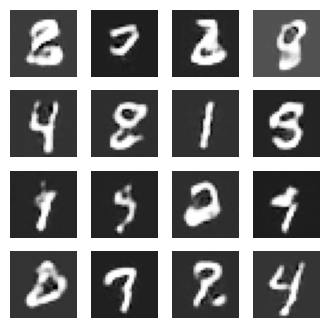

In [ ]:
# Step 6: Start the training process
# This trains the GAN for the specified number of epochs
train(dataset, EPOCHS)
